In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files    are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from fastai.vision.all import *
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')
train.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
train = train.pivot(index='id', columns='class', values='segmentation').reset_index()
train.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0001,NaN,NaN,NaN
1,case101_day20_slice_0002,NaN,NaN,NaN
2,case101_day20_slice_0003,NaN,NaN,NaN
3,case101_day20_slice_0004,NaN,NaN,NaN
4,case101_day20_slice_0005,NaN,NaN,NaN


In [5]:
path = Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train')
file_names = get_image_files(path)

In [7]:
file_names

(#38496) [Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0016_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0115_266_266_1.50_1.50.png'),Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0073_266_26

In [12]:
file_names[0].parts

('/',
 'kaggle',
 'input',
 'uw-madison-gi-tract-image-segmentation',
 'train',
 'case36',
 'case36_day14',
 'scans',
 'slice_0006_266_266_1.50_1.50.png')

In [72]:
def get_slice_id(fname):
    return fname.parts[6] + '_' + fname.parts[8][:10]

In [73]:
def read_image(fname):
    image = cv2.imread(fname, cv2.IMREAD_UNCHANGED).astype('float32')
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)
    
    return image

In [89]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

In [6]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle,shape, color=1):
    split = np.array(mask_rle.split(), dtype =int)

    starts = split[0::2] - 1
    lengths = split[1::2]
    ends = starts + lengths
    
    height, width = shape
    mask = np.zeros(height*width, dtype=np.uint8)
    
    for low, high in zip(starts, ends):
        mask[low:high] = color
   
    return mask.reshape((height,width))

In [84]:
def generate_masks(fname, df = train):
    slice_id = get_slice_id(fname)
    slice_row = df[df['id'] == slice_id]
    width, height = fname.parts[8][11:18].split('_')
    width, height = int(width), int(height)
    
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
        segmentation = slice_row[location]
        segmentation = segmentation.item()
        if isinstance(segmentation, str):
            # mask_rle = data[data['class'] == each]['segmentation'].tolist()
            mask_shape = (height, width)
            mask[..., k] = rle_decode(segmentation, mask_shape, color=255)

    return mask

In [7]:
# customize it to suit our needs of multi channel
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o))

In [8]:
import matplotlib.patches as mpatches

@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x_i = x[i] / x[i].max()
        show_image(x_i, ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='large_bowel')
        green_patch = mpatches.Patch(color='green', label='small_bowel')
        blue_patch = mpatches.Patch(color='blue', label='stomach')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0]/2)

In [8]:
tfms = [[load_image, PILImageBW.create], [generate_masks, PILMask.create]]

dsets = Datasets(file_names, tfms)

dls = dsets.dataloaders(after_item=[Resize(224), ToTensor], after_batch=[IntToFloatTensor])

dls.show_batch(nrows=2, ncols=4, figsize=(15, 7))

NameError: name 'generate_masks' is not defined

In [27]:
file_names[0]

Path('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png')

In [9]:
train['partial_fname'] = train.id
fname_df = pd.DataFrame({'partial_fname': [f'{fname.parts[-3]}_slice_{fname.parts[-1][6:10]}' for fname in file_names],
                         'fname': file_names})

train = train.merge(fname_df, on='partial_fname').drop('partial_fname', axis=1)

train['case_id'] = train.id.apply(lambda x: x.split('_')[0])
train['day_num'] = train.id.apply(lambda x: x.split('_')[1])

train['slice_width'] = train["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
train['slice_height'] = train["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))


In [12]:
train.head()

,id,large_bowel,small_bowel,stomach,fname,case_id,day_num,slice_width,slice_height
0,case101_day20_slice_0001,NaN,NaN,NaN,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png,case101,day20,266,266
1,case101_day20_slice_0002,NaN,NaN,NaN,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0002_266_266_1.50_1.50.png,case101,day20,266,266
2,case101_day20_slice_0003,NaN,NaN,NaN,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0003_266_266_1.50_1.50.png,case101,day20,266,266
3,case101_day20_slice_0004,NaN,NaN,NaN,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0004_266_266_1.50_1.50.png,case101,day20,266,266
4,case101_day20_slice_0005,NaN,NaN,NaN,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0005_266_266_1.50_1.50.png,case101,day20,266,266


**2.5D data with 3 channels and 2 strides, keeping the main fname in the middle.**

In [10]:
channels = 3
stride = 2

for j,i in enumerate(range(-1*(channels - channels//2-1), channels//2+1)):
    method = 'ffill'
    if i <= 0: method = 'bfill'
    train[f'fname_{j:02}'] = train.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)
    
train['fnames'] = train[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()

**Load these slices into one image and apply transformations for the data loader. Updating functions to take input a row instead of file name.**

**As images are of different sizes, the slices need to be pre padded**

In [11]:
def pad_img(img, up_size=None):
    if up_size is None:
        return img
    # height, width
    shape_img = np.array(img.shape[:2])
    resize = np.array(up_size)
    if np.any(shape_img != resize):
        diff = resize - shape_img
        pad_0 = diff[0] 
        pad_1 = diff[1]
        pad_y = [pad_0//2, pad_0//2 + pad_0%2]
        pad_x = [pad_1//2, pad_1//2 + pad_1%2]
        img = np.pad(img, [pad_y, pad_x])
        img = img.reshape(*resize)
    return img        

In [12]:
def unpad_img(img, up_size, org_size):
    # height, width
    shape_img = np.array(org_size)
    resize = np.array(up_size)
    if np.any(shape_img != resize):
        diff = resize - shape_img
        pad_0 = diff[0] 
        pad_1 = diff[1]
        pad_y = [pad_0//2, pad_0//2 + pad_0%2]
        pad_x = [pad_1//2, pad_1//2 + pad_1%2]
        img = img[pad_y[0]:-pad_y[1], pad_x[0]:-pad_x[1], :]
        img = img.reshape((*shape_img,3))
    return img

In [13]:
def load_image(fname, up_size=None):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return pad_img(img, up_size)

In [14]:
def get_25D_image(row, up_size=None):
    if up_size:
        imgs = np.zeros((*up_size, len(row['fnames'])))
    else:
        imgs = np.zeros((row['slice_height'], row['slice_width'], len(row['fnames'])))
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname, up_size)
        imgs[..., i] += img
    return imgs.astype(np.uint8)

if up_size:
        height, width = up_size
    else:
        width, height = row['slice_width'], row['slice_height']
    width, height = int(width), int(height)
    
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
        segmentation = row[location]
        if isinstance(segmentation, str):
            # segmentation = segmentation.item()  
            # mask_rle = data[data['class'] == each]['segmentation'].tolist()
            mask_shape = (height, width)
            mask[..., k] += pad_img(rle_decode(segmentation, mask_shape, color=255), up_size)
    print("row and mask shape")
    print(row['id'])
    print(mask.shape)

In [15]:
def get_masks(row, up_size=None):
    if up_size:
        mask = np.zeros((*up_size, 3))
    else:
        mask = np.zeros((row['slice_height'], row['slice_width'], 3))
        
    if isinstance(row['large_bowel'], str):
        mask[..., 0] += pad_img(rle_decode(row['large_bowel'], shape=(row['slice_height'], row['slice_width']), color=255), up_size)
    if isinstance(row['small_bowel'], str):
        mask[..., 1] += pad_img(rle_decode(row['small_bowel'], shape=(row['slice_height'], row['slice_width']), color=255), up_size)
    if isinstance(row['stomach'], str):
        mask[..., 2] += pad_img(rle_decode(row['stomach'], shape=(row['slice_height'], row['slice_width']), color=255), up_size)
        
    return mask.astype(np.uint8)

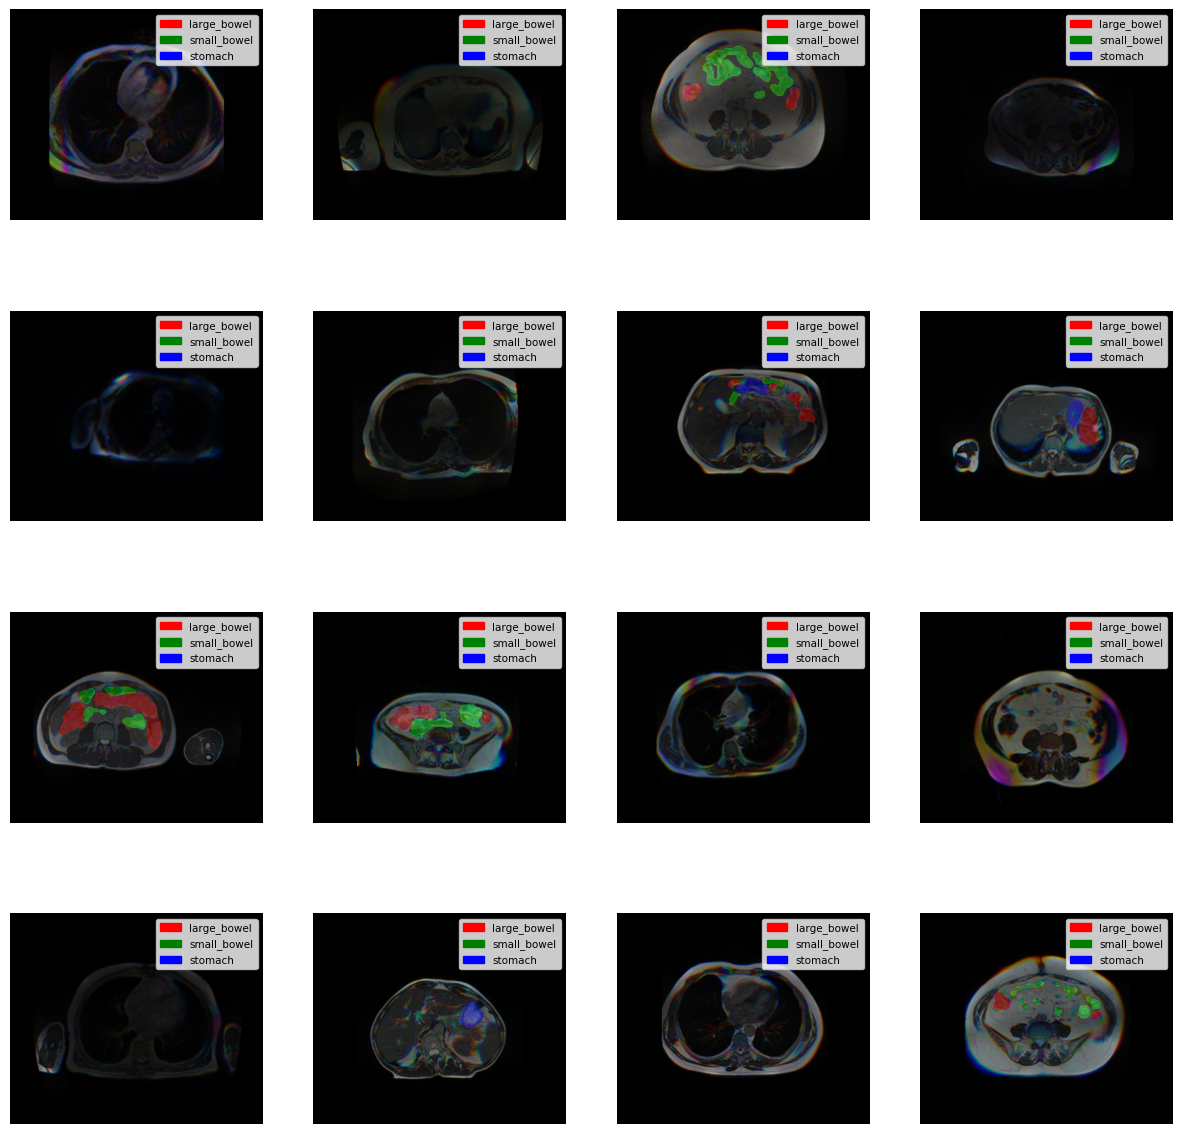

In [16]:
up_size = (320, 384)

tfms = [[partial(get_25D_image, up_size = up_size), PILImage.create], 
        [partial(get_masks, up_size = up_size), PILMask.create]]

splits = RandomSplitter()(train)
dsets = Datasets(train, tfms, splits=splits)

dls = dsets.dataloaders(bs=16,after_item=[ToTensor], after_batch=[IntToFloatTensor])

dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

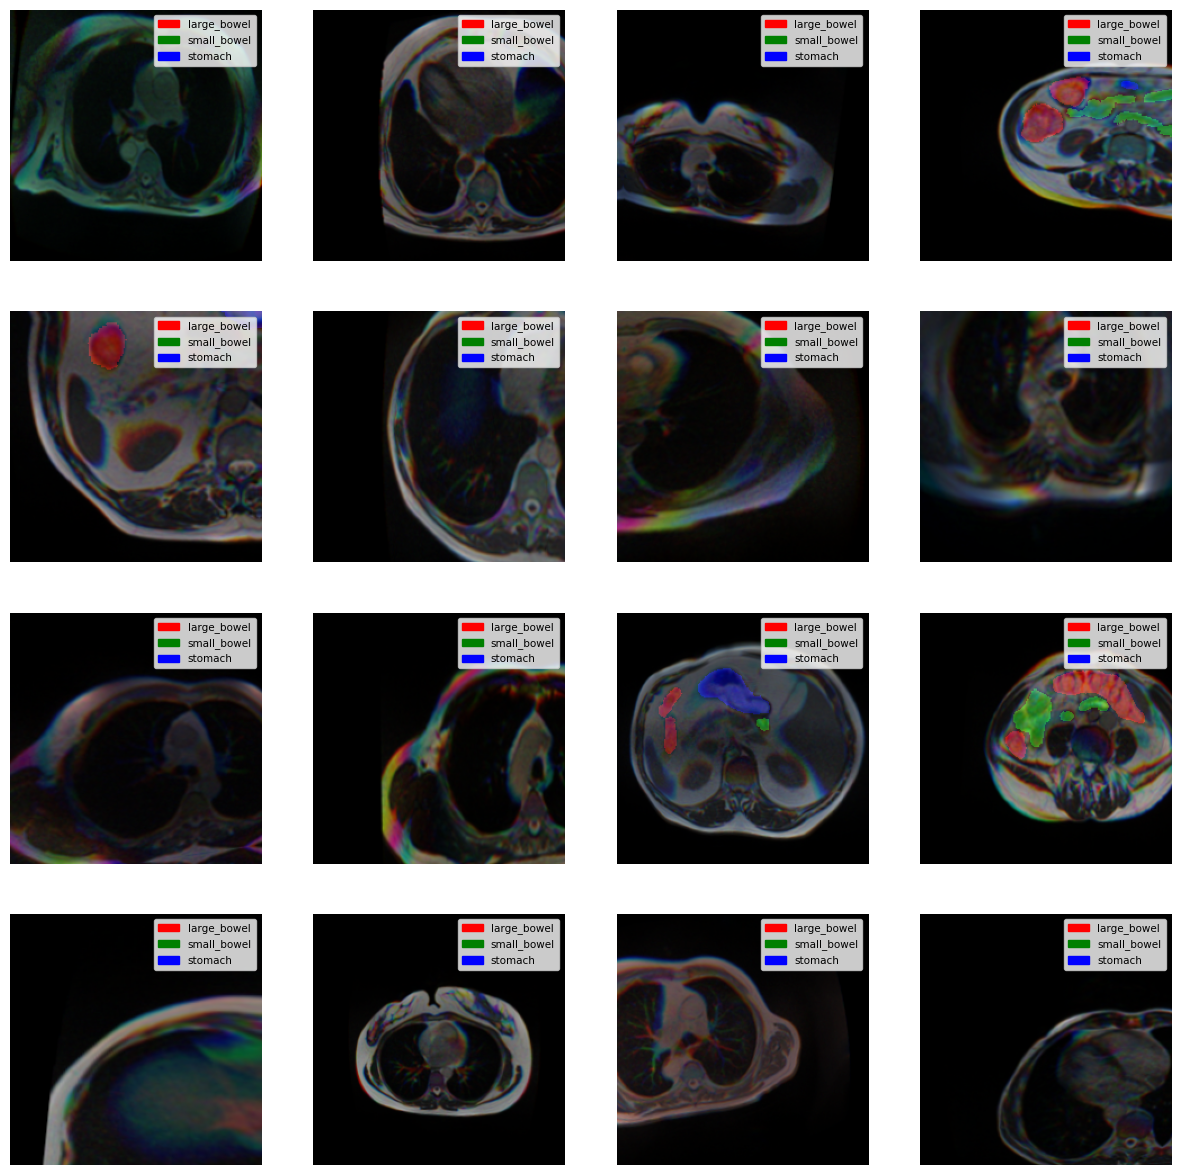

In [17]:
up_size = (320, 384)

tfms = [[partial(get_25D_image, up_size = up_size), PILImage.create], 
        [partial(get_masks, up_size = up_size), PILMask.create]]

splits = RandomSplitter()(train)
dsets = Datasets(train, tfms, splits=splits)

dls = dsets.dataloaders(bs=16,after_item=[RandomResizedCrop(224), ToTensor], after_batch=[IntToFloatTensor, *aug_transforms(mult=0.8)])

dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

**Augmentations:**

In [18]:
import albumentations as A

def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return A.Compose([
            A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            A.HorizontalFlip(p=p),
            A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            A.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
                interpolation=cv2.INTER_AREA, p=p),
            A.HorizontalFlip(p=0.5*p),
            A.OneOf([
                A.MotionBlur(p=0.2*p),
                A.MedianBlur(blur_limit=3, p=0.1*p),
                A.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            A.GaussNoise(var_limit=0.001, p=0.2*p),
            A.OneOf([
                A.OpticalDistortion(p=0.3*p),
                A.GridDistortion(p=0.1*p),
                A.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
            A.Sharpen(p=0.2*p),
        ])

def get_test_aug(img_size, crop=0.9):
    crop_size = round(crop*img_size[0])
    return  A.Compose([
        A.CenterCrop(height=crop_size, width=crop_size),
    ])

In [19]:
import cv2

class AlbumentationsTransform(ItemTransform, RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx): self.idx = split_idx
    
    def encodes(self, x):
        if len(x) > 1:
            img, mask = x
            if self.idx == 0:
                aug = self.train_aug(image=np.array(img), mask=np.array(mask))    
            else:
                aug = self.valid_aug(image=np.array(img), mask=np.array(mask))
            return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
        else:
            img = x[0]
            aug = self.valid_aug(image=np.array(img))
            return PILImage.create(aug["image"])

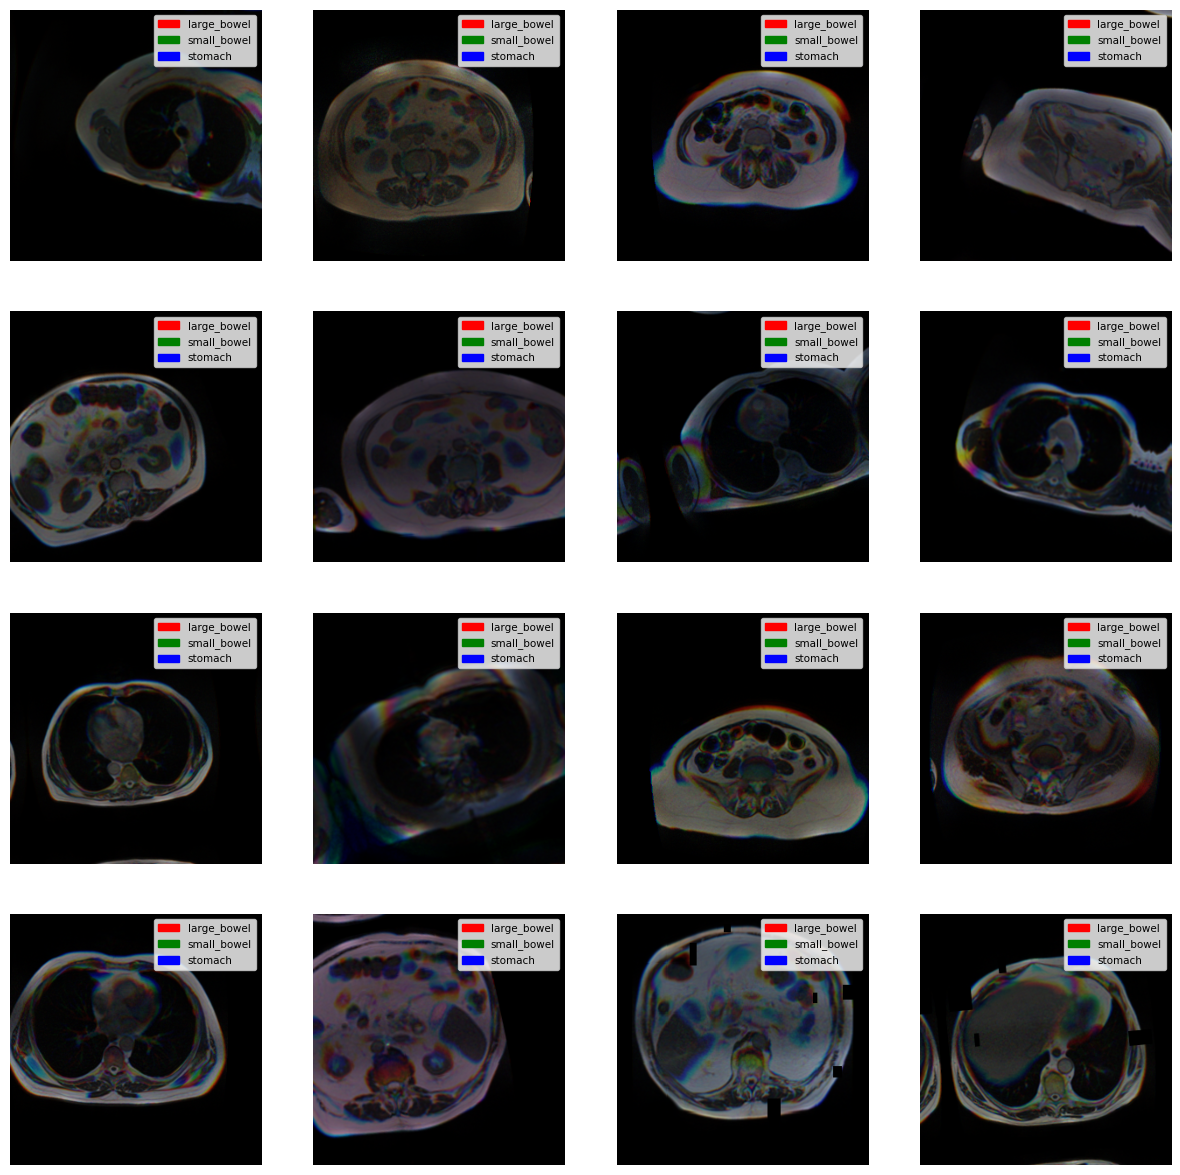

In [20]:
dev_df = train.sample(frac=0.2)

up_size = (320, 384)

tfms = [[partial(get_25D_image, up_size=up_size), PILImage.create],
        [partial(get_masks, up_size=up_size), PILMask.create]]

splits = RandomSplitter()(dev_df)
dsets = Datasets(train, tfms, splits=splits)

albu_aug = AlbumentationsTransform(get_train_aug(up_size), get_test_aug(up_size))

dls = dsets.dataloaders(bs=16, after_item=[albu_aug, ToTensor], after_batch=[IntToFloatTensor(div_mask=255),  Normalize.from_stats(*imagenet_stats)])

dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

**Training**

In [21]:
from scipy.spatial.distance import directed_hausdorff


def dice_coeff_adj(inp, targ):
    inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0

def hd_dist_per_slice(inp, targ, seed):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, seed)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_adj(inp, targ, seed=42):
    inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j], seed))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric_adj(inp, targ, seed=42):
    hd_score_per_batch = hd_dist_adj(inp, targ, seed)
    dice_score_per_batch = dice_coeff_adj(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

**Loss Functions**

In [22]:
class DiceBCEModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        return 0.5*(1 - dice) + 0.5*bce_loss
    
class DiceBCELoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, thresh=0.5, **kwargs):
        super().__init__(DiceBCEModule, *args, eps=eps, from_logits=from_logits, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)
    
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
        
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

class FocalTverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class FocalTverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(FocalTverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
        
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [23]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=c3ba9519c7767eb0e5014b43449f13f51985079da49fd634a8d3db4c793583b7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=67ee02a62c69702b0db1e0a365b5240e4ec47a3038e403576782565355ca92ec
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing in

In [24]:
import segmentation_models_pytorch as smp

def build_model(encoder_name, in_c=3, classes=3, weights="imagenet"):
    model = smp.Unet(
        encoder_name=encoder_name,      
        encoder_weights=weights,     
        in_channels=in_c,                
        classes=classes,        
        activation=None
    )
    return model

In [25]:
def smp_splitter(model):
    model_layers = list(model.children())
    encoder_params = params(model_layers[0])
    decoder_params = params(model_layers[1]) + params(model_layers[2])
    return L(encoder_params, decoder_params)

In [26]:
model = build_model('efficientnet-b0')
metrics = [dice_coeff_adj, hd_dist_adj, custom_metric_adj]
loss_func = ComboLoss()
splitter = smp_splitter

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 155MB/s]


In [32]:
learn = Learner(dls, model, metrics=metrics, loss_func=loss_func, splitter=splitter).to_fp16()
learn.freeze()

In [33]:
learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,1.085458,0.950113,0.435370,0.626902,0.550290,04:05


epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,0.770370,0.559381,0.638766,0.804691,0.738321,04:07
1,0.587849,0.448626,0.721146,0.853405,0.800501,03:28
2,0.480822,0.404626,0.766233,0.912097,0.853751,03:29


SuggestedLRs(valley=0.00019054606673307717)

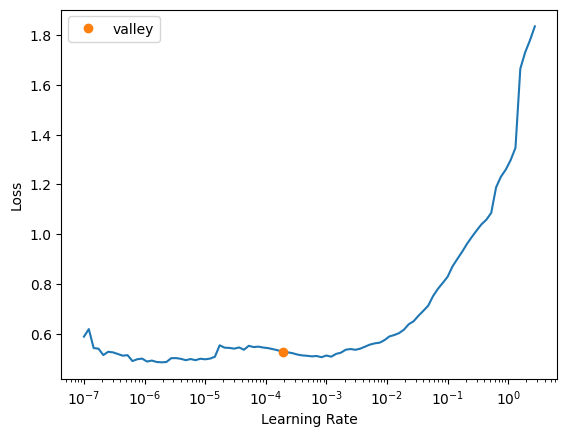

In [34]:
learn.lr_find()

In [35]:
lr = 1e-3

In [29]:

learn.fit_flat_cos(3, lr)

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,2.218992,2.131037,0.095634,0.246279,0.186021,03:59
1,1.738096,1.569740,0.378859,0.703136,0.573425,03:24
2,1.110038,0.972088,0.565112,0.768731,0.687283,03:26


In [36]:
learn.unfreeze()
learn.fit_flat_cos(5, slice(lr/300, lr/3))

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,0.460413,0.406486,0.763776,0.912378,0.852937,03:25
1,0.486845,0.398367,0.766448,0.899528,0.846296,03:26
2,0.444027,0.381159,0.772724,0.908127,0.853965,03:30
3,0.443379,0.375098,0.775363,0.911147,0.856833,03:27
4,0.450120,0.370847,0.776830,0.910101,0.856792,03:29
